2025-05-13 14:54:55.399083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747148095.641283      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747148095.710035      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Balancing dataset with augmentation...


2025-05-13 14:57:30.894479: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

===== Training ResNet50 =====
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


338/338 ━━━━━━━━━━━━━━━━━━━━ 923s 3s/step - accuracy: 0.2348 - loss: 2.3192 - val_accuracy: 0.4887 - val_loss: 1.2996
Epoch 2/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 895s 3s/step - accuracy: 0.3565 - loss: 1.7006 - val_accuracy: 0.5591 - val_loss: 1.1396
Epoch 3/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 897s 3s/step - accuracy: 0.4282 - loss: 1.4416 - val_accuracy: 0.6154 - val_loss: 1.0376
Epoch 4/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 899s 3s/step - accuracy: 0.5062 - loss: 1.2512 - val_accuracy: 0.6313 - val_loss: 0.9740
Epoch 5/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 902s 3s/step - accuracy: 0.5334 - loss: 1.1655 - val_accuracy: 0.6417 - val_loss: 0.9411
Epoch 6/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 892s 3s/step - accuracy: 0.5686 - loss: 1.0798 - val_accuracy: 0.6707 - val_loss: 0.8988
Epoch 7/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 897s 3s/step - accuracy: 0.5956 - loss: 1.0134 - val_accuracy: 0.6642 - val_loss: 0.8781
Epoch 8/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 917s 3s/step - accuracy: 0.6102 - loss: 0.9915 - val_accuracy: 0.668

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


34/34 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step

📄 Classification Report for ResNet50
              precision    recall  f1-score   support

           1       0.98      0.75      0.85       270
           2       0.78      0.70      0.74       253
           3       0.62      0.77      0.68       236
           4       0.68      0.53      0.59       197
           5       0.57      0.95      0.71       112

    accuracy                           0.72      1068
   macro avg       0.72      0.74      0.72      1068
weighted avg       0.75      0.72      0.73      1068



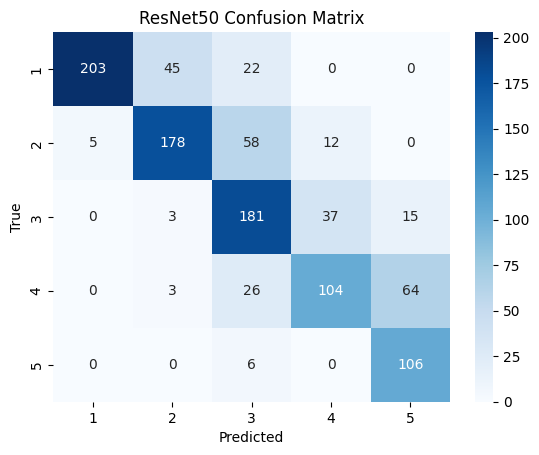

In [1]:
# --- Imports ---
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import albumentations as A

# --- Paths & Constants ---
train_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/train/images'
val_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/val/images'
test_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/test/images'
RESNET_SIZE = 224

# --- Augmentations ---
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomGamma(p=0.3),
    A.MotionBlur(p=0.3),
    A.CLAHE(p=0.2),
    A.GaussNoise(p=0.3),
    A.HueSaturationValue(p=0.3),
    A.GridDistortion(p=0.2)])

# --- Data Loading ---
def load_data_from_folder(folder, img_size):
    image_paths = glob(os.path.join(folder, '*.jpg'))
    images, labels = [], []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (img_size, img_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = path.split("_")[-2]
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

X_train, y_train = load_data_from_folder(train_img_dir, RESNET_SIZE)
X_val, y_val = load_data_from_folder(val_img_dir, RESNET_SIZE)
X_test, y_test = load_data_from_folder(test_img_dir, RESNET_SIZE)

le = LabelEncoder()
y_train_enc = to_categorical(le.fit_transform(y_train))
y_val_enc = to_categorical(le.transform(y_val))
y_test_enc = to_categorical(le.transform(y_test))

# --- Augmenting Minority Classes ---
def augment_minority_classes(X, y, augment, le):
    print("Balancing dataset with augmentation...")
    counts = Counter(y)
    max_count = max(counts.values())

    new_X, new_y = list(X), list(y)
    for label in counts:
        imgs = [x for x, l in zip(X, y) if l == label]
        for _ in range(max_count - counts[label]):
            img = imgs[np.random.randint(len(imgs))]
            aug_img = augment(image=img)['image']
            new_X.append(aug_img)
            new_y.append(label)

    new_X = np.array(new_X)
    new_y_enc = to_categorical(le.transform(new_y))
    return new_X, new_y_enc, new_y

X_train_bal, y_train_bal, y_train_bal_raw = augment_minority_classes(X_train, y_train, augment, le)

# --- Model Building & Training ---
def build_resnet_model(input_shape, num_classes):
    base = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    base.trainable = False
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=output)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test, preprocessor, model_name):
    print(f"\n===== Training {model_name} =====")
    X_train = preprocessor(X_train.astype('float32'))
    X_val = preprocessor(X_val.astype('float32'))
    X_test = preprocessor(X_test.astype('float32'))

    early = EarlyStopping(patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs=20, batch_size=32, callbacks=[early])

    preds = model.predict(X_test)
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print(f"\n📄 Classification Report for {model_name}")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# --- Train ResNet50 ---
resnet_model = build_resnet_model((RESNET_SIZE, RESNET_SIZE, 3), len(le.classes_))
train_and_evaluate(resnet_model, X_train_bal, y_train_bal, X_val, y_val_enc, X_test, y_test_enc, preprocess_resnet, "ResNet50")


2025-05-14 12:16:12.402587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747224972.680991      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747224972.758714      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Balancing dataset with augmentation...


2025-05-14 12:18:35.406541: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

===== Training ResNet50 Fine-Tuned + Focal Loss =====
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


338/338 ━━━━━━━━━━━━━━━━━━━━ 1354s 4s/step - accuracy: 0.5329 - loss: 0.2425 - val_accuracy: 0.6876 - val_loss: 0.1009
Epoch 2/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 1293s 4s/step - accuracy: 0.6456 - loss: 0.1208 - val_accuracy: 0.7045 - val_loss: 0.0819
Epoch 3/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 1301s 4s/step - accuracy: 0.6693 - loss: 0.0974 - val_accuracy: 0.6979 - val_loss: 0.0800
Epoch 4/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 1364s 4s/step - accuracy: 0.6618 - loss: 0.0933 - val_accuracy: 0.6998 - val_loss: 0.0726
Epoch 5/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 1283s 4s/step - accuracy: 0.6703 - loss: 0.0863 - val_accuracy: 0.7064 - val_loss: 0.0690
Epoch 6/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 1290s 4s/step - accuracy: 0.6859 - loss: 0.0798 - val_accuracy: 0.7045 - val_loss: 0.0689
Epoch 7/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 1343s 4s/step - accuracy: 0.6806 - loss: 0.0806 - val_accuracy: 0.7139 - val_loss: 0.0681
Epoch 8/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 1306s 4s/step - accuracy: 0.6884 - loss: 0.0746 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


34/34 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step

 Classification Report for ResNet50 Fine-Tuned + Focal Loss
              precision    recall  f1-score   support

           1       0.97      0.76      0.85       270
           2       0.78      0.69      0.74       253
           3       0.64      0.73      0.68       236
           4       0.63      0.56      0.60       197
           5       0.57      0.96      0.71       112

    accuracy                           0.72      1068
   macro avg       0.72      0.74      0.71      1068
weighted avg       0.75      0.72      0.72      1068



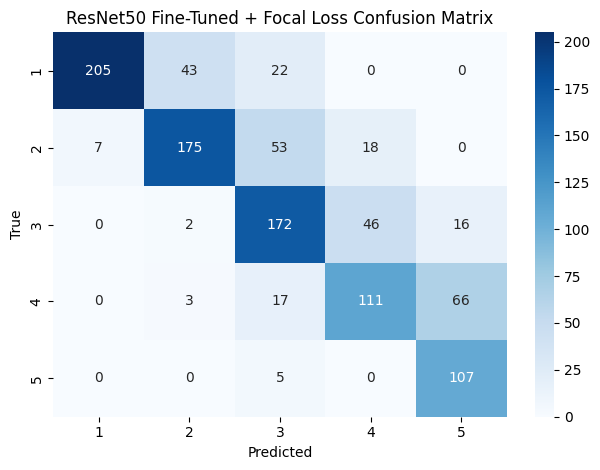

In [1]:
# --- Imports ---
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import albumentations as A

# --- Paths & Constants ---
train_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/train/images'
val_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/val/images'
test_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/test/images'
RESNET_SIZE = 224

# --- Augmentations ---
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomGamma(p=0.3),
    A.MotionBlur(p=0.3),
    A.CLAHE(p=0.2),
    A.GaussNoise(p=0.3),
    A.HueSaturationValue(p=0.3),
    A.GridDistortion(p=0.2)])

# --- Focal Loss ---
def focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma) * y_true
        loss = tf.reduce_sum(weight * cross_entropy, axis=1)
        return tf.reduce_mean(loss)
    return loss_fn

# --- Load Images ---
def load_data_from_folder(folder, img_size):
    image_paths = glob(os.path.join(folder, '*.jpg'))
    images, labels = [], []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (img_size, img_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = path.split("_")[-2]
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

X_train, y_train = load_data_from_folder(train_img_dir, RESNET_SIZE)
X_val, y_val = load_data_from_folder(val_img_dir, RESNET_SIZE)
X_test, y_test = load_data_from_folder(test_img_dir, RESNET_SIZE)

# --- Label Encoding ---
le = LabelEncoder()
y_train_enc = to_categorical(le.fit_transform(y_train))
y_val_enc = to_categorical(le.transform(y_val))
y_test_enc = to_categorical(le.transform(y_test))

# --- Augment Minority Classes ---
def augment_minority_classes(X, y, augment, le):
    print("Balancing dataset with augmentation...")
    counts = Counter(y)
    max_count = max(counts.values())

    new_X, new_y = list(X), list(y)
    for label in counts:
        imgs = [x for x, l in zip(X, y) if l == label]
        for _ in range(max_count - counts[label]):
            img = imgs[np.random.randint(len(imgs))]
            aug_img = augment(image=img)['image']
            new_X.append(aug_img)
            new_y.append(label)

    new_X = np.array(new_X)
    new_y_enc = to_categorical(le.transform(new_y))
    return new_X, new_y_enc, new_y

X_train_bal, y_train_bal, y_train_bal_raw = augment_minority_classes(X_train, y_train, augment, le)

# --- Model Building ---
def build_resnet_finetuned(input_shape, num_classes):
    base = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    
    # Unfreeze last 30 layers for fine-tuning
    for layer in base.layers[:-30]:
        layer.trainable = False
    for layer in base.layers[-30:]:
        layer.trainable = True

    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss=focal_loss(gamma=2.0, alpha=0.25),
                  metrics=['accuracy'])
    return model

# --- Training + Evaluation ---
def train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test, preprocessor, model_name):
    print(f"\n===== Training {model_name} =====")
    X_train = preprocessor(X_train.astype('float32'))
    X_val = preprocessor(X_val.astype('float32'))
    X_test = preprocessor(X_test.astype('float32'))

    early = EarlyStopping(patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs=20, batch_size=32, callbacks=[early])

    preds = model.predict(X_test)
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print(f"\n Classification Report for {model_name}")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_,
                yticklabels=le.classes_, cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# --- Run Everything ---
resnet_model = build_resnet_finetuned((RESNET_SIZE, RESNET_SIZE, 3), len(le.classes_))
train_and_evaluate(resnet_model, X_train_bal, y_train_bal, X_val, y_val_enc,
                   X_test, y_test_enc, preprocess_resnet, "ResNet50 Fine-Tuned + Focal Loss")
